# AE33 and ABCD co-located analysis

In [79]:
#dataframe, plotting, and statistical libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [117]:
plt.style.use('mpl_config.mplstyle')

In [81]:
from rx_burn_datetime_index_config import *

# Functions

In [83]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

def linRegConstTol(ABCD,AE33,tolUp,ABCD_MAE,AE33_MAE):
    mask = ~np.isnan(ABCD) & ~np.isnan(AE33) & (ABCD < tolUp) & (AE33 < tolUp) & (ABCD > ABCD_MAE) & (AE33 > AE33_MAE)
    X = ABCD[mask]
    Y = AE33[mask]
    #X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    r = model.fit()
    
    s = r.params[0]
    #b = r.params[0]
    r2 = r.rsquared
    s_uci = r.conf_int().values[0,0]
    s_lci = r.conf_int().values[0,1]
    #b_uci = r.conf_int().values[0,0]
    #b_lci = r.conf_int().values[0,1]
    
    rmse = mean_squared_error(Y,X,squared=False)
    d_unity = abs(s-1)
    return s,r2,s_lci,s_uci,rmse,d_unity

def pearson(X,Y):
    mask = ~np.isnan(X) & ~np.isnan(Y)
    X = X[mask]
    Y = Y[mask]
    p = stats.pearsonr(X,Y)
    
    return p[0]

def linRegConst(X,Y):
    mask = ~np.isnan(X) & ~np.isnan(Y)
    X = X[mask]
    Y = Y[mask]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    r = model.fit()
    
    s = r.params[1]
    b = r.params[0]
    r2 = r.rsquared
    
    return s,b,r2

def mape(ABCD,AE33):
    mask = ~np.isnan(ABCD) & ~np.isnan(AE33)
    X = ABCD[mask]
    Y = AE33[mask]
    
    ab = abs((X-Y)/Y).replace(np.inf,np.nan).mean()*100
    return ab

## Import aligned ABCD and AE33 data

In [84]:
# AE33 Hz all data
fname = '/Users/jdabutler/Documents/+github/rx burn/aligned CSV/'
AE33hz = pd.read_csv(fname+'ground_AE33_1Hz_align.csv')
AE33hz.datetime = pd.to_datetime(AE33hz.datetime)
AE33hz.set_index('datetime',inplace=True)

In [85]:
# exclude minutes without 70% 1 Hz measurements of ABCD 
ABCDhz = pd.read_csv(fname+'ground_ABCD_1Hz_align.csv')
ABCDhz.datetime = pd.to_datetime(ABCDhz.datetime)
ABCDhz.set_index('datetime',inplace=True)
#ABCDhz.drop('Unnamed: 0',axis=1,inplace=True)

ABCD10 = ABCDhz.resample('10S').mean()
ABCD10['ATN'] = ABCDhz['ATN'].resample('10S').max()
ABCDmin = ABCDhz.resample('1T').mean()
ABCDmin['ATN'] = ABCDhz['ATN'].resample('1T').max()

#ABCD10.datetime = pd.to_datetime(ABCD10.datetime)
#ABCDmin.datetime = pd.to_datetime(ABCDmin.datetime)

#ABCD10.set_index('datetime',inplace=True)
#ABCDmin.set_index('datetime',inplace=True)

## Create sample-only AE33 dataframe, (dfs)

In [86]:
dfs = AE33hz[AE33hz.Status.isin([0,128])].copy()

dfs.loc[:,'BC6'] = dfs.loc[:,'BC6']/1000 #convert from ng/m3 to ug/m3

dfs10 = dfs.resample('10S').mean()
dfsT = dfs.resample('1T').mean()

# ABCD versus AE33

## Create merged AE33 and ABCD 1 Hz, 10 sec, and 10 min datasets

In [88]:
HZ = pd.merge(dfs.BC6,ABCDhz[['ATN','BC']],how='outer',left_index = True,right_index = True)
S10 = pd.merge(dfs10.BC6,ABCD10[['ATN','BC']],how='outer',left_index = True,right_index = True)
MIN = pd.merge(dfsT.BC6,ABCDmin[['ATN','BC']],how='outer',left_index=True,right_index=True)

## Find instrument noise and mean absolute errors (MAE)

In [89]:
#back1 = logATN.AAE1[d3S:d3b].append(logATN.AAE1[d4c:d4b1])
#back2 = logATN.AAE2[d3S:d3b].append(logATN.AAE2[d4c:d4b1])

backHZ = pd.concat([HZ[d3S:d3b],HZ[d4c:d4b1]])
backS10 = pd.concat([S10[d3S:d3b],S10[d4c:d4b1]])
backMIN = pd.concat([MIN[d3S:d3b],MIN[d4c:d4b1]])

backHZ.dropna(how='all',inplace=True)
backMIN.dropna(how='all',inplace=True)

In [90]:
# drop the initial noise on the ABCD from turn on and 1 Hz ABCD where concentration > abs(1000)
# Day 3
backHZ.loc['2021-04-22 10:52:00':'2021-04-22 11:05:00','BC'] = np.nan
backS10.loc['2021-04-22 10:52:00':'2021-04-22 11:05:00','BC'] = np.nan
backMIN.loc['2021-04-22 10:52:00':'2021-04-22 11:05:00','BC'] = np.nan

# abs(1000) threshold
backHZ.loc[abs(backHZ.BC)>1000,'BC'] = np.nan

# Day 4
backHZ.loc['2021-04-23 10:05:00':'2021-04-23 10:08:00','BC'] = np.nan
backS10.loc['2021-04-23 10:05:00':'2021-04-23 10:08:00','BC'] = np.nan
backMIN.loc['2021-04-23 10:05:00':'2021-04-23 10:08:00','BC'] = np.nan

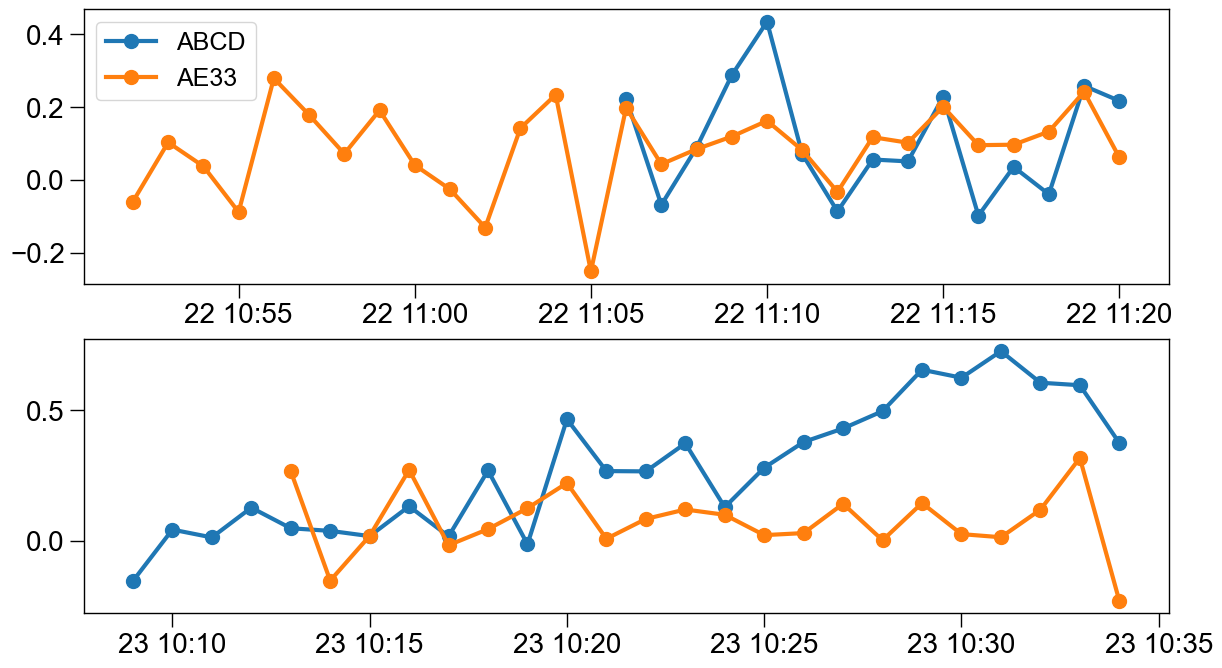

In [118]:
BC6 = '#000080'
abcd = '#2E8B57'

fig,ax = plt.subplots(2,1)

tp = [d3S,d3b,d4c,d4b1]

for i in range(2):
    ax[i].plot(backMIN.loc[tp[i*2]:tp[2*i+1],['BC','BC6']],'o-')
    
ax[0].legend(labels=['ABCD','AE33'])

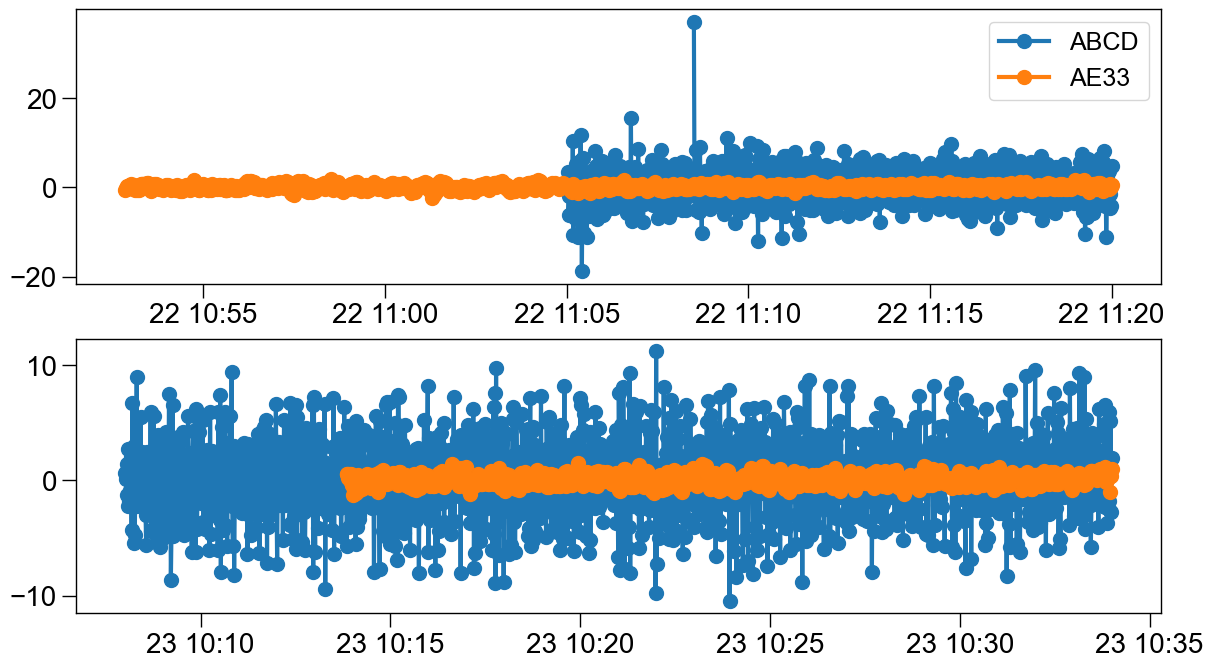

In [119]:
fig,ax = plt.subplots(2,1)

tp = [d3S,d3b,d4c,d4b1]

for i in range(2):
    ax[i].plot(backHZ.loc[tp[i*2]:tp[2*i+1],['BC','BC6']],'o-')
    
ax[0].legend(labels=['ABCD','AE33'])

In [93]:
BC_hz_mae = abs(backHZ.BC).mean()
BC6_hz_mae = abs(backHZ.BC6).mean()
BC_10_mae = abs(backS10.BC).mean()
BC6_10_mae = abs(backS10.BC6).mean()
BC_min_mae = abs(backMIN.BC).mean()
BC6_min_mae = abs(backMIN.BC6).mean()

In [94]:
print(BC6_hz_mae,BC_hz_mae)
print(BC6_10_mae,BC_10_mae)
print(BC6_min_mae,BC_min_mae)

0.3823560872624912 2.8105374288039053
0.223563480963481 0.5386469327420548
0.11878082788671022 0.23810149940023978


In [95]:
BC_hz_mae = abs(backHZ.BC).sum() / len(backHZ.loc[~np.isnan(backHZ.BC),'BC'])
BC6_hz_mae = abs(backHZ.BC6).sum() / len(backHZ.loc[~np.isnan(backHZ.BC6),'BC6'])
BC_10_mae = abs(backS10.BC).sum() / len(backS10.loc[~np.isnan(backS10.BC),'BC'])
BC6_10_mae = abs(backS10.BC6).sum() / len(backS10.loc[~np.isnan(backS10.BC6),'BC6'])
BC_min_mae = abs(backMIN.BC).sum() / len(backMIN.loc[~np.isnan(backMIN.BC),'BC'])
BC6_min_mae = abs(backMIN.BC6).sum() / len(backMIN.loc[~np.isnan(backMIN.BC6),'BC6'])

BC_min_mae

0.23810149940023978

In [96]:
print(BC6_hz_mae,BC_hz_mae)
print(BC6_10_mae,BC_10_mae)
print(BC6_min_mae,BC_min_mae)

0.3823560872624912 2.8105374288039053
0.223563480963481 0.5386469327420548
0.11878082788671022 0.23810149940023978


In [97]:
tol = 0.94
upper_tol = 100 #ug/m3

def retain4regress(BC,tolUp,mae):
    x = (BC.dropna() < tolUp) & (BC.dropna() > mae)
    per = sum(x)/len(x)
    return per

def exceedTol(BC,tolUp):
    x = BC.dropna() > tolUp 
    per = sum(x) / len(x)
    return per

print('1 hz ABCD BC retained: {:2f}'.format(retain4regress(HZ.BC,upper_tol,BC_hz_mae)))
print('1 hz AE33 BC retained: {:2f}'.format(retain4regress(HZ.BC6,upper_tol,BC6_hz_mae)))
print('10 sec ABCD BC retained: {:2f}'.format(retain4regress(S10.BC,upper_tol,BC_10_mae)))
print('10 sec AE33 BC retained: {:2f}'.format(retain4regress(S10.BC6,upper_tol,BC6_10_mae)))
print('1 min ABCD BC retained: {:2f}'.format(retain4regress(MIN.BC,upper_tol,BC_min_mae)))
print('1 min AE33 BC retained: {:2f}'.format(retain4regress(MIN.BC6,upper_tol,BC6_min_mae)))

print('1 hz ABCD BC exceed tol: {:2f}'.format(exceedTol(HZ.BC,upper_tol)))
print('1 hz AE33 BC exceed tol: {:2f}'.format(exceedTol(HZ.BC6,upper_tol)))
print('10 sec ABCD BC exceed tol: {:2f}'.format(exceedTol(S10.BC,upper_tol)))
print('10 sec AE33 BC exceed tol: {:2f}'.format(exceedTol(S10.BC6,upper_tol)))
print('1 min ABCD BC exceed tol: {:2f}'.format(exceedTol(MIN.BC,upper_tol)))
print('1 min AE33 BC exceed tol: {:2f}'.format(exceedTol(MIN.BC6,upper_tol)))

tols = np.arange(0,2000,10)
abHz = np.zeros(len(tols))
aeHz = np.zeros(len(tols))
ab10 = np.zeros(len(tols))
ae10 = np.zeros(len(tols))
abMin = np.zeros(len(tols))
aeMin = np.zeros(len(tols))

for i, t in enumerate(tols):
    abHz[i] = retain4regress(HZ.BC,t,BC_hz_mae)
    aeHz[i] = retain4regress(HZ.BC6,t,BC6_hz_mae)
    ab10[i] = retain4regress(S10.BC,t,BC_10_mae)
    ae10[i] = retain4regress(S10.BC6,t,BC6_10_mae)
    abMin[i] = retain4regress(MIN.BC,t,BC_min_mae)
    aeMin[i] = retain4regress(MIN.BC6,t,BC6_min_mae)

abHz = abHz / abHz.max()
aeHz = aeHz / aeHz.max()
ab10 = ab10 / ab10.max()
ae10 = ae10 / ae10.max()
abMin = abMin / abMin.max()
aeMin = aeMin / aeMin.max()

1 hz ABCD BC retained: 0.432676
1 hz AE33 BC retained: 0.678339
10 sec ABCD BC retained: 0.520500
10 sec AE33 BC retained: 0.697931
1 min ABCD BC retained: 0.613497
1 min AE33 BC retained: 0.757920
1 hz ABCD BC exceed tol: 0.040646
1 hz AE33 BC exceed tol: 0.036399
10 sec ABCD BC exceed tol: 0.043791
10 sec AE33 BC exceed tol: 0.039750
1 min ABCD BC exceed tol: 0.052585
1 min AE33 BC exceed tol: 0.063363


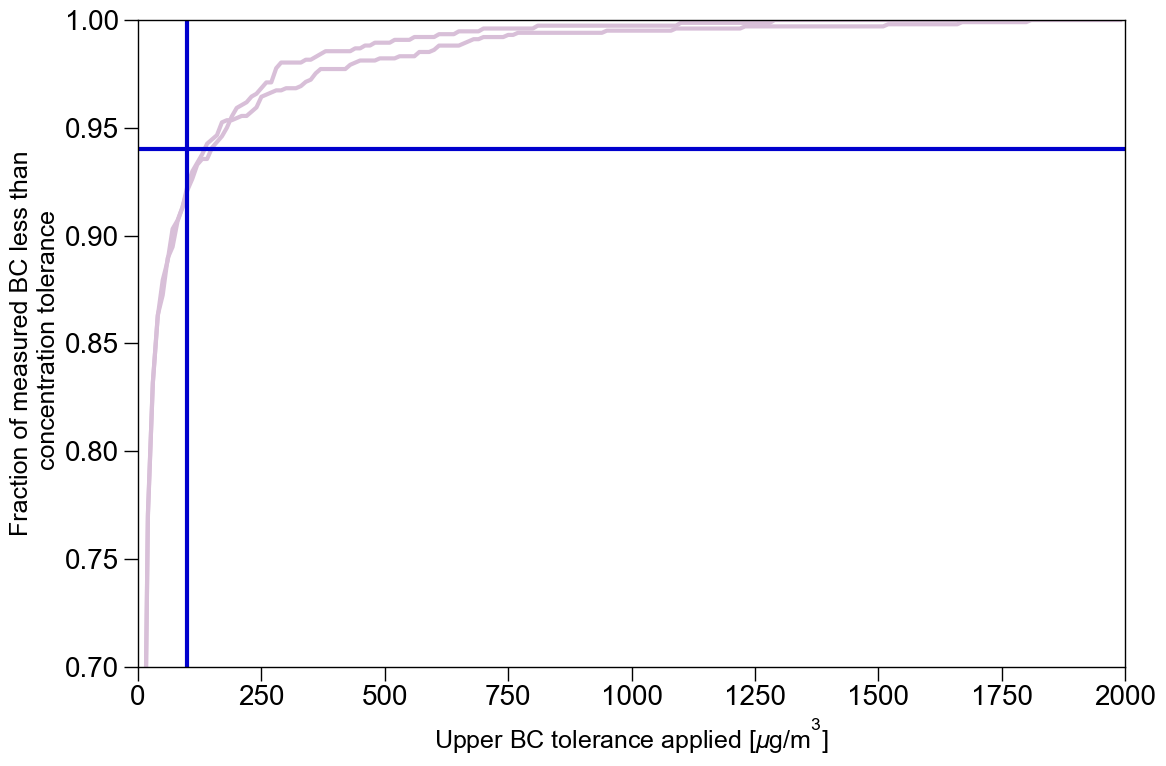

In [98]:
fig,ax = plt.subplots(figsize=(12,8))
c = '#D8BFD8'

#ax.plot(tols,abHz,color = c)
#ax.plot(tols,aeHz,color = c)
#ax.plot(tols,ab10,color = c)
#ax.plot(tols,ae10,color = c)
ax.plot(tols,abMin,color = c)
ax.plot(tols,aeMin,color = c)
ax.plot([upper_tol,upper_tol],[0.7,1],color='#0000CD')
ax.plot([0,2000],[tol,tol],color='#0000CD')

ax.set_xlabel('Upper BC tolerance applied [$\mu$g/m$^3$]')
ax.set_ylabel('Fraction of measured BC less than\n concentration tolerance')
ax.set_ylim([0.7,1])
ax.set_xlim([0,2000])

fig.tight_layout()

path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/plots/ABCD-AE33 analyses/'
#fig.savefig(path+'upperConcTol.png')

## Linear regression of (1) QAQC ABCD (no LAC) vs. AE33 data and (2) QAQCed ABCD with LAC vs. AE33 data

In [99]:
s_hz,r2_hz,s_lci_hz,s_uci_hz,rmse,du = linRegConstTol(HZ.BC,HZ.BC6,upper_tol,BC_hz_mae,BC6_hz_mae)
s_10,r2_10,s_lci_10,s_uci_10,rmse,du = linRegConstTol(S10.BC,S10.BC6,upper_tol,BC_10_mae,BC6_10_mae)
smin,r2min,s_lciMin,s_uciMin,rmse,du = linRegConstTol(MIN.BC,MIN.BC6,upper_tol,BC_min_mae,BC6_10_mae)

In [100]:
a = np.arange(0,1.0,0.05)
M_hz = []
R2_hz = []
rmse_hz = []
du_hz = []

M_10 = []
R2_10 = []
rmse_10 = []
du_10 = []

M_min = []
R2_min = []
rmse_min = []
du_min = []

# average = backMIN.mean()
# BC_mean = average['BC']
# BC6_mean = average['BC6']


for la in a:
    HZ['BC_corr_'+str(la)] = HZ.BC / ((la*np.exp(-HZ.ATN/100))+(1-la))
    S10['BC_corr_'+str(la)] = S10.BC / ((la*np.exp(-S10.ATN/100))+(1-la))
    MIN['BC_corr_'+str(la)] = MIN.BC / ((la*np.exp(-MIN.ATN/100))+(1-la))
    
    
    s,r2,s_lci,s_uci,rmse,du = linRegConstTol(HZ['BC_corr_'+str(la)],HZ.BC6,upper_tol,BC_hz_mae,BC6_hz_mae)
    
    M_hz.append(s)
    R2_hz.append(r2)
    rmse_hz.append(rmse)
    du_hz.append(du)
    
    s,r2,s_lci,s_uci,rmse,du = linRegConstTol(S10['BC_corr_'+str(la)],S10.BC6,upper_tol,BC_10_mae,BC6_10_mae)
    
    M_10.append(s)
    R2_10.append(r2)
    rmse_10.append(rmse)
    du_10.append(du)
    
    s,r2,s_lci,s_uci,rmse,du = linRegConstTol(MIN['BC_corr_'+str(la)],MIN.BC6,upper_tol,BC_min_mae,BC6_min_mae)
    
    M_min.append(s)
    R2_min.append(r2)
    rmse_min.append(rmse)
    du_min.append(du)

linreg = list(zip(a,
                  M_hz,R2_hz,rmse_hz,du_hz,
                  M_10,R2_10,rmse_10,du_10,
                  M_min,R2_min,rmse_min,du_min))

    
OLS = pd.DataFrame(linreg, columns = ['AAP',
                                      'slope hz','r2 hz','rmse hz','du hz',
                                      'slope 10 sec','r2 10 sec','rmse 10 sec','du 10 sec',
                                      'slope min','r2 min','rmse min','du min'])
OLS.set_index('AAP',inplace=True)

In [101]:
OLS

,slope hz,r2 hz,rmse hz,du hz,slope 10 sec,r2 10 sec,rmse 10 sec,du 10 sec,slope min,r2 min,rmse min,du min
AAP,,,,,,,,,,,,
0.00,0.867194,0.628716,13.307478,0.132806,1.061232,0.710405,11.082944,0.061232,1.144462,0.845625,7.904211,0.144462
0.05,0.861853,0.629591,13.290299,0.138147,1.051418,0.707969,11.067658,0.051418,1.131974,0.845435,7.861893,0.131974
0.10,0.855760,0.630575,13.283503,0.144240,1.040072,0.708128,11.044060,0.040072,1.119216,0.845136,7.823842,0.119216
0.15,0.850331,0.630350,13.294293,0.149669,1.028464,0.708211,11.028685,0.028464,1.106175,0.844717,7.790770,0.106175
0.20,0.841679,0.629979,13.327918,0.158321,1.017607,0.705689,11.020004,0.017607,1.092834,0.844166,7.763487,0.092834
0.25,0.834380,0.629642,13.344393,0.165620,1.005493,0.705597,11.018159,0.005493,1.079175,0.843472,7.742918,0.079175
0.30,0.825898,0.628421,13.391055,0.174102,0.993070,0.705397,11.020012,0.006930,1.065181,0.842619,7.730113,0.065181
0.35,0.816515,0.628069,13.442386,0.183485,0.988848,0.708787,10.949390,0.011152,1.050829,0.841593,7.726264,0.050829
0.40,0.807658,0.627308,13.486652,0.192342,0.975625,0.708325,10.960397,0.024375,1.036099,0.840375,7.732726,0.036099


Best Artifact Adjustment Parameter at a = 0.5

In [102]:
# define chosen artifact adjustment parameter
AAPbest = 0.5

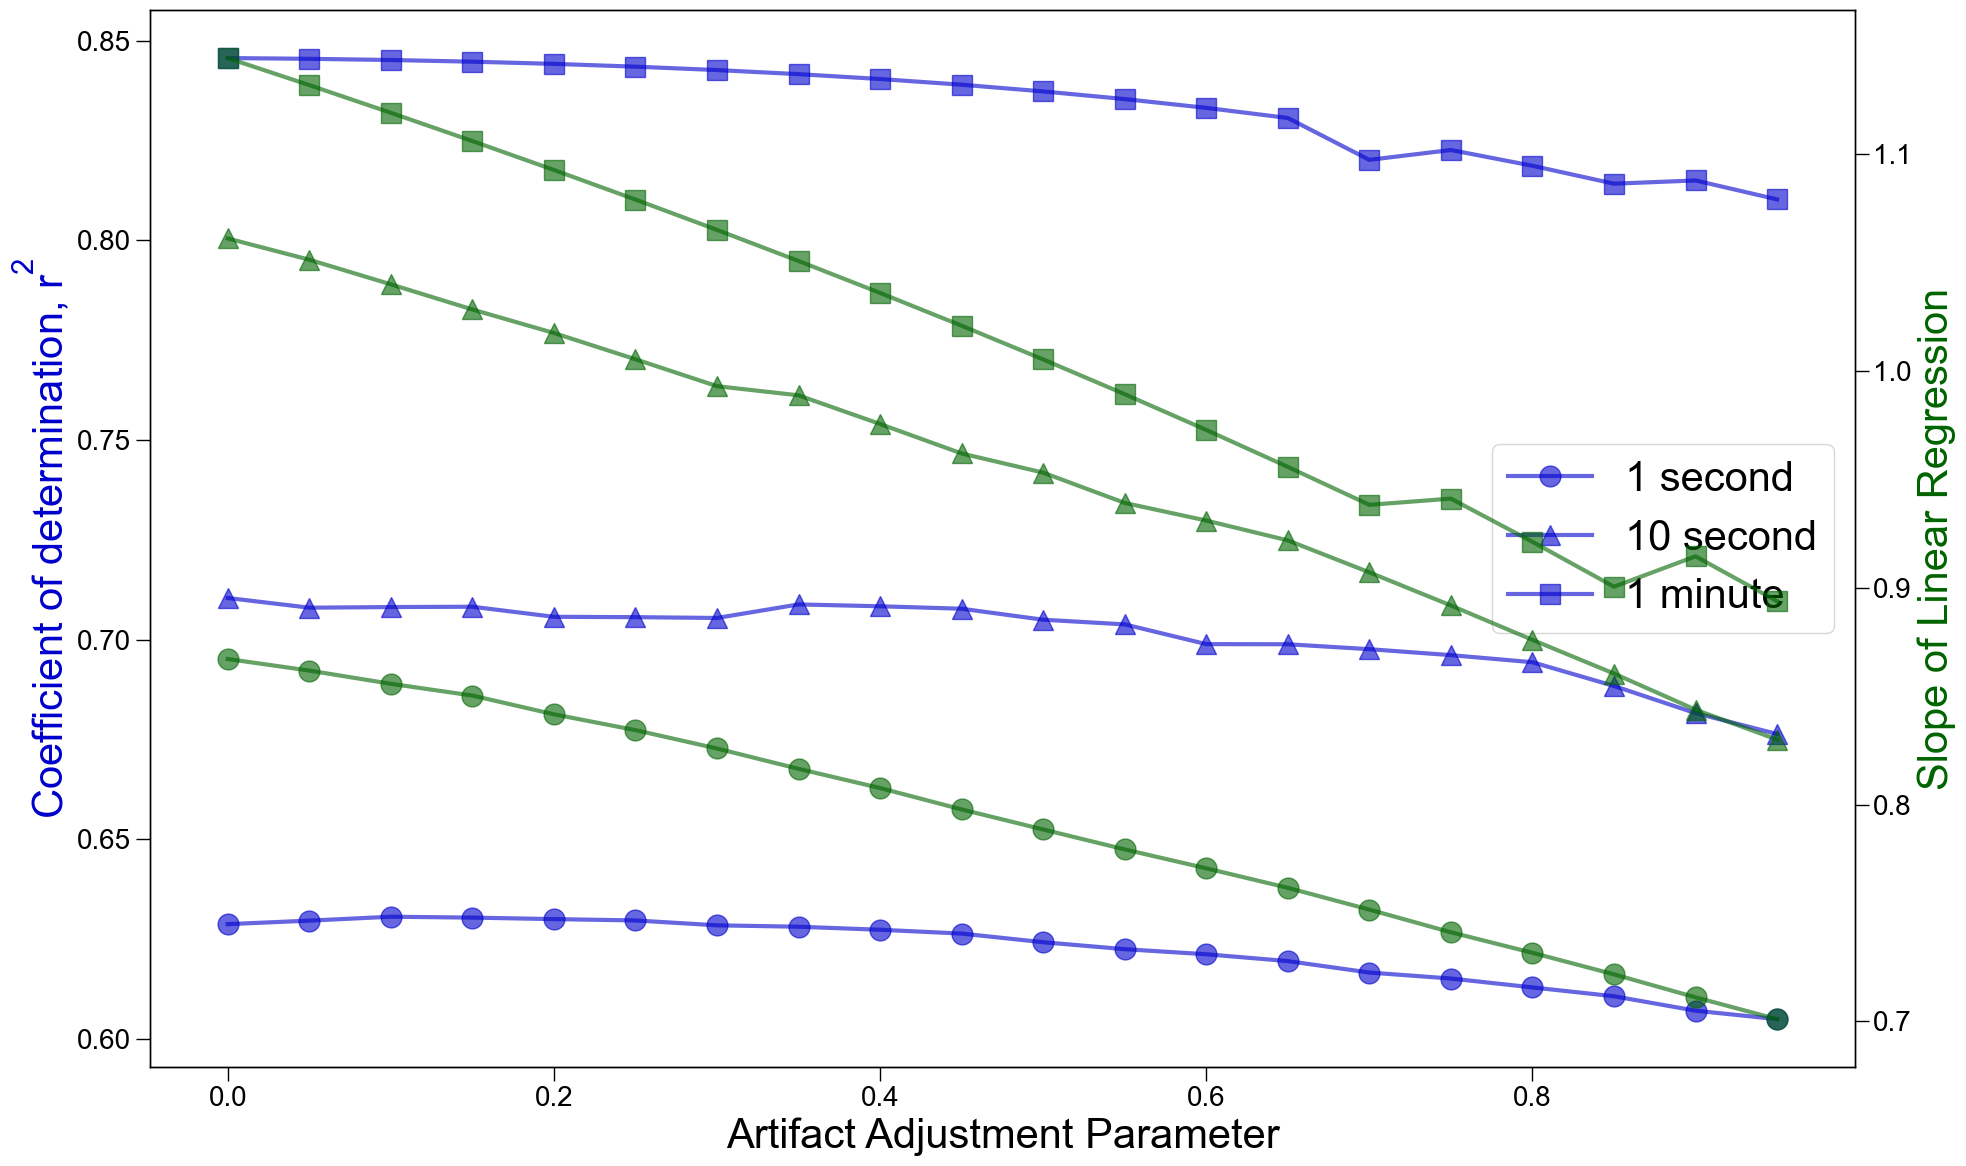

In [103]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
a = 0.6
blue = '#0000CD'
gre = '#006400'

ax.plot(OLS.index,OLS['r2 hz'],'o-',label = '1 second',ms=15,color = blue,alpha = 0.6)
ax.plot(OLS.index,OLS['r2 10 sec'],'^-',label = '10 second',ms = 15,color = blue,alpha = 0.6)
ax.plot(OLS.index,OLS['r2 min'],'s-',label = '1 minute',ms=15,color = blue,alpha = 0.6)
#ax.plot([AAPbest,AAPbest],[0.3,0.9],'-',lw=5,color=blue,zorder=10,alpha = 0.6)

ax.set_ylabel('Coefficient of determination, r$^2$',fontsize = 30,color = blue)

ax2.plot(OLS.index,OLS['slope hz'],'o-',label = '1 Hz',ms =15,color = gre,alpha = a)
ax2.plot(OLS.index,OLS['slope 10 sec'],'^-',label = '10 sec',ms = 15,color =gre,alpha = a)
ax2.plot(OLS.index,OLS['slope min'],'s-',label = '1 minute',ms=15,color = gre,alpha = a)
#ax2.plot([0,2],[1,1],color = '#32CD32',alpha = a)

ax2.set_ylabel('Slope of Linear Regression',fontsize = 30,color = gre)

ax.set_xlabel('Artifact Adjustment Parameter',fontsize = 30)

ax.legend(fontsize = 30,loc='best')

fig.tight_layout()
path ='/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/plots/ABCD-AE33 analyses/'
#fig.savefig(path+'slope_r2_vs_aap.png')

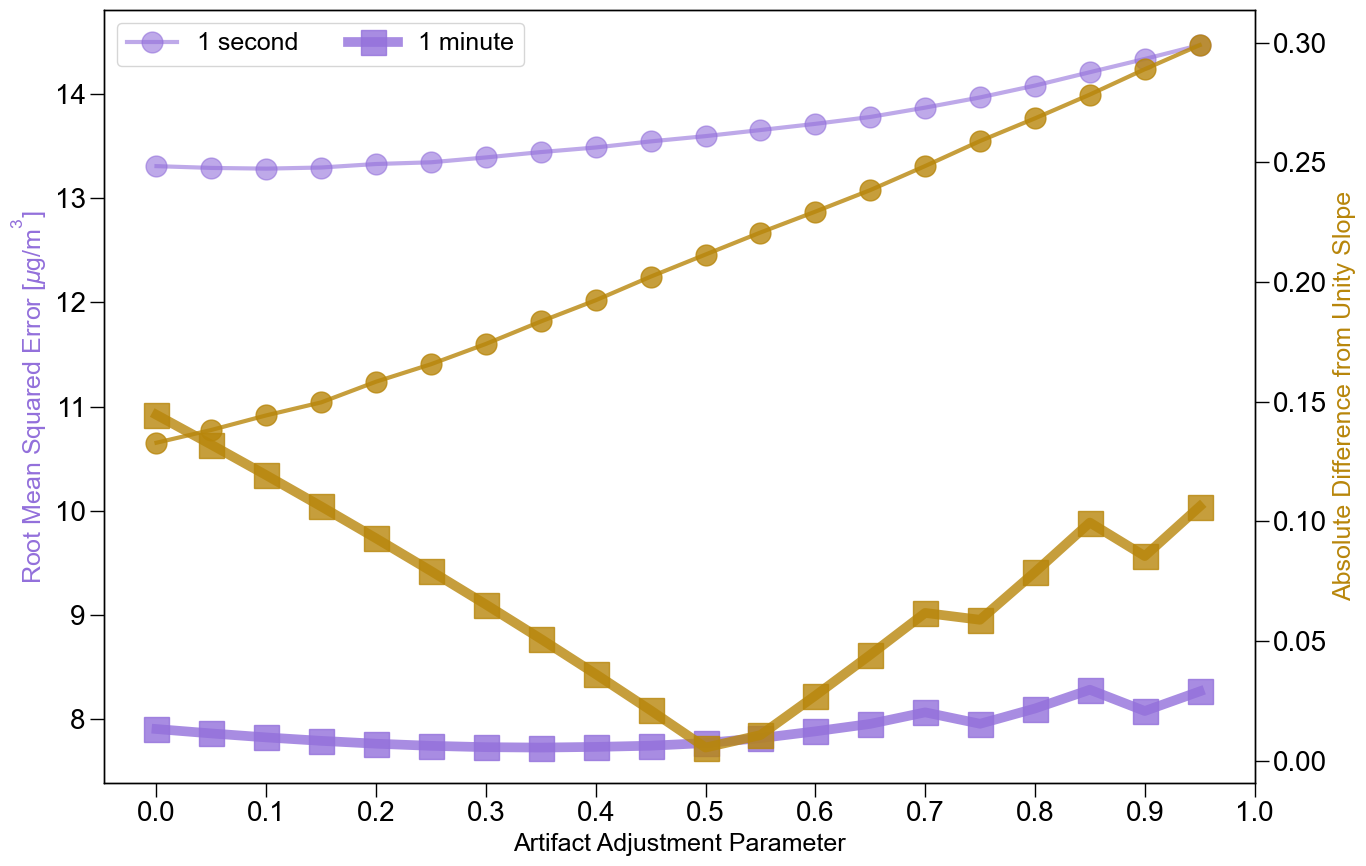

In [104]:
fig, ax = plt.subplots(figsize=(14,9))
ax2 = ax.twinx()
a = 0.8
rmse = '#9370DB'
sl = '#B8860B'

ax.plot(OLS.index,OLS['rmse hz'],'o-',label = '1 second',ms=15,color = rmse,alpha = 0.6)
#ax.plot(OLS.index,OLS['rmse 10 sec'],'^-',label = '10 second',ms = 15,color = rmse,alpha = a)
ax.plot(OLS.index,OLS['rmse min'],'s-',label = '1 minute',ms=18,color = rmse,alpha = a,lw=7)
#ax.plot([AAPbest,AAPbest],[0.3,0.9],'-',lw=5,color=blue,zorder=10,alpha = 0.6)

ax.set_ylabel('Root Mean Squared Error [$\mu$g/m$^3$]',color = rmse)

ax2.plot(OLS.index,OLS['du hz'],'o-',label = '1 Hz',ms =15,color = sl,alpha = a)
#ax2.plot(OLS.index,OLS['du 10 sec'],'^-',label = '10 sec',ms = 15,color =sl,alpha = a)
ax2.plot(OLS.index,OLS['du min'],'s-',label = '1 minute',ms=18,color = sl,alpha = a,lw=7)
#ax2.plot([0,2],[1,1],color = '#32CD32',alpha = a)

ax2.set_ylabel('Absolute Difference from Unity Slope',color = sl)

ax.set_xlabel('Artifact Adjustment Parameter')
ax.set_xticks(np.arange(0,1.01,.1))

ax.legend(fontsize = 18,loc='best',ncol=2)

fig.tight_layout()
path='/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/plots/ABCD-AE33 analyses/'
#fig.savefig(path+'rmse_devUnity_vs_aap.png')

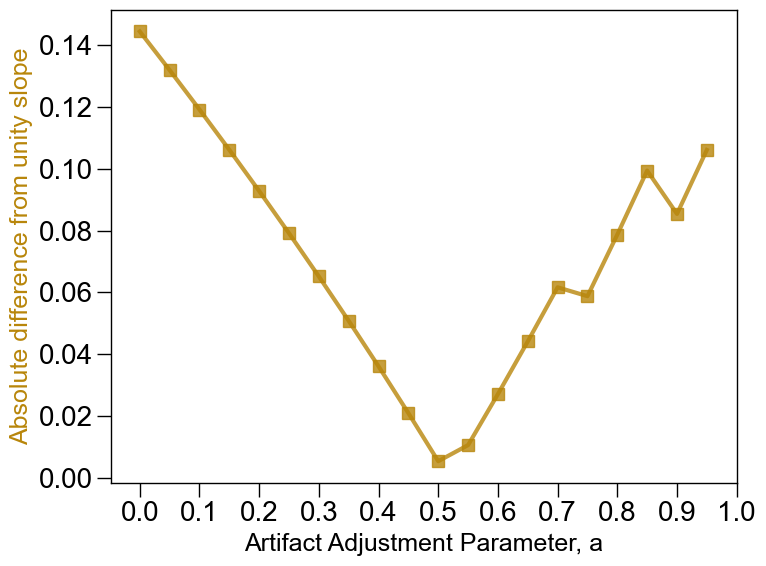

In [105]:
fig, ax = plt.subplots(figsize=(8,6))
sl = '#B8860B'
#ax.plot(OLS.index,OLS['du hz'],'o-',label = '1 second',ms =15,color = sl,alpha = a)
#ax.plot(OLS.index,OLS['du 10 sec'],'^-',label = '10 second',ms = 15,color =sl,alpha = a)
ax.plot(OLS.index,OLS['du min'],'s-',label = '1 minute',ms=8,color = sl,alpha = a)
#ax2.plot([0,2],[1,1],color = '#32CD32',alpha = a)

ax.set_ylabel('Absolute difference from unity slope',color = sl)

ax.set_xlabel('Artifact Adjustment Parameter, a')
ax.set_xticks(np.arange(0,1.01,.1))

#ax.legend(fontsize = 30,loc='best')

fig.tight_layout()
path='/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/clean plots/'
fig.savefig(path+'deviationFromUnity.png')

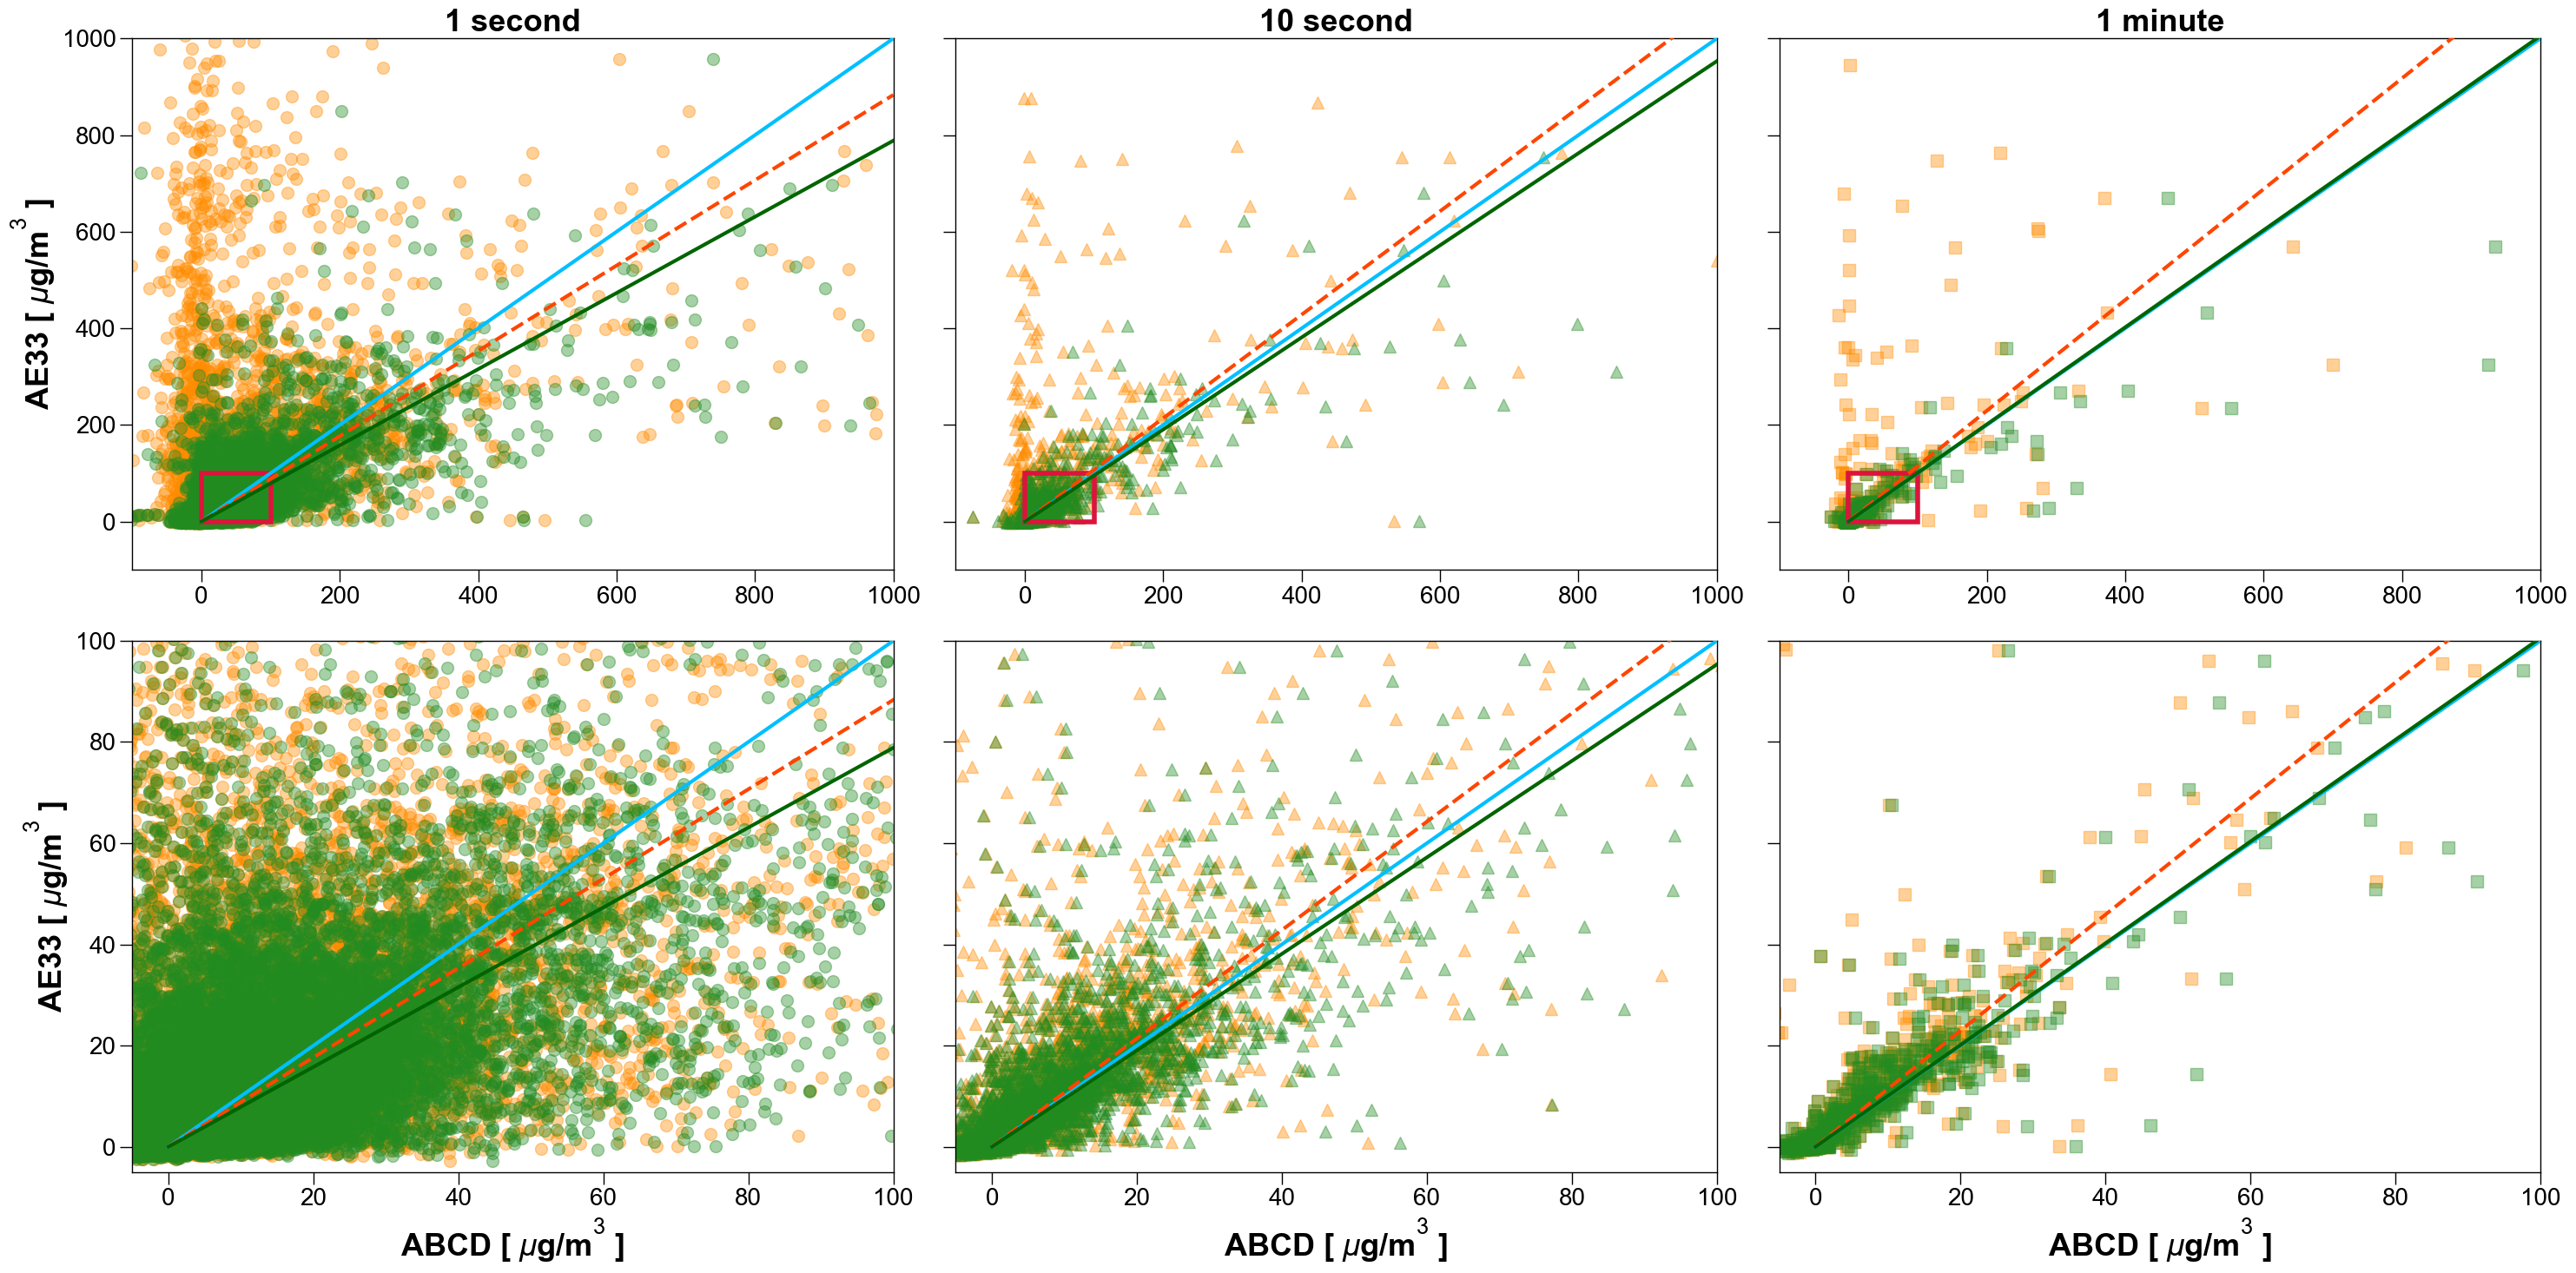

In [106]:
from matplotlib.patches import Rectangle

lb = -100
hb = 1000
lbt = -5
hbt = 100
end = hb
alp = 0.4
x = np.linspace(0,end,11)


fig, ax = plt.subplots(2,3,sharey='row',figsize=(30,15))

ax[0,0].plot(HZ.BC,HZ.BC6,'o',alpha = alp,color = '#FF8C00')
ax[0,0].plot(HZ['BC_corr_' + str(AAPbest)],HZ.BC6,'o',alpha = alp,color = '#228B22')
ax[0,0].plot([0,end],[0,end],color = '#00BFFF',zorder = 15, label = '1:1 line')
ax[0,0].plot(x,s_hz*x,'--', color ='#FF4500',zorder = 20,label = 'linear regression no LAC applied')
ax[0,0].plot(x,x*OLS.loc[AAPbest,'slope hz'],'-',color ='#006400',zorder = 20,label = 'linear regression LAC applied')

ax[0,0].set_xlim([lb,hb])
ax[0,0].set_ylim([lb,hb])
ax[0,0].set_title('1 second',fontsize = 26,fontweight='bold')
ax[0,0].add_patch(Rectangle((0, 0), hbt, hbt, edgecolor = '#DC143C', facecolor = 'none', fill=True,lw=4,zorder = 10))
ax[0,0].set_ylabel('AE33 [ $\mu$g/m$^3$ ]',fontsize = 26,fontweight='bold')

ax[0,1].plot(S10.BC,S10.BC6,'^',alpha = alp,color = '#FF8C00')
ax[0,1].plot(S10['BC_corr_' + str(AAPbest)],S10.BC6,'^',alpha = alp,color = '#228B22')
ax[0,1].plot([0,end],[0,end],color = '#00BFFF',zorder = 15, label = '1:1 line')
ax[0,1].plot(x,s_10*x,'--', color ='#FF4500',zorder = 20,label = 'linear regression no LAC applied')
ax[0,1].plot(x,x*OLS.loc[AAPbest,'slope 10 sec'],'-',color ='#006400',zorder = 20,label = 'linear regression LAC applied')

ax[0,1].set_xlim([lb,hb])
ax[0,1].set_ylim([lb,hb])
ax[0,1].set_title('10 second',fontsize = 26,fontweight='bold')
ax[0,1].add_patch(Rectangle((0, 0), hbt, hbt, edgecolor = '#DC143C', facecolor = 'none', fill=True,lw=4,zorder = 10))

ax[0,2].plot(MIN.BC,MIN.BC6,'s',alpha = alp,color = '#FF8C00')
ax[0,2].plot(MIN['BC_corr_' + str(AAPbest)],MIN.BC6,'s',alpha = alp,color = '#228B22')
ax[0,2].plot([0,end],[0,end],color = '#00BFFF',zorder = 15, label = '1:1 line')
ax[0,2].plot(x,smin*x,'--', color ='#FF4500',zorder = 20,label = 'linear regression no LAC applied')
ax[0,2].plot(x,x*OLS.loc[AAPbest,'slope min'],'-',color ='#006400',zorder = 20,label = 'linear regression LAC applied')

ax[0,2].set_xlim([lb,hb])
ax[0,2].set_ylim([lb,hb])
ax[0,2].set_title('1 minute',fontsize = 26,fontweight='bold')
ax[0,2].add_patch(Rectangle((0, 0), hbt, hbt, edgecolor = '#DC143C', facecolor = 'none', fill=True,lw=4,zorder = 10))

ax[1,0].plot(HZ.BC,HZ.BC6,'o',alpha = alp,color = '#FF8C00')
ax[1,0].plot(HZ['BC_corr_' + str(AAPbest)],HZ.BC6,'o',alpha = alp,color = '#228B22')
ax[1,0].plot([0,end],[0,end],color = '#00BFFF',zorder = 15, label = '1:1 line')
ax[1,0].plot(x,s_hz*x,'--', color ='#FF4500',zorder = 20,label = 'linear regression no LAC applied')
ax[1,0].plot(x, x*OLS.loc[AAPbest,'slope hz'],'-',color ='#006400',zorder = 20,label = 'linear regression LAC applied')

ax[1,0].set_xlim([lbt,hbt])
ax[1,0].set_ylim([lbt,hbt])
ax[1,0].set_xlabel('ABCD [ $\mu$g/m$^3$ ]',fontsize = 26,fontweight='bold')
ax[1,0].set_ylabel('AE33 [ $\mu$g/m$^3$ ]',fontsize = 26,fontweight='bold')

ax[1,1].plot(S10.BC,S10.BC6,'^',alpha = alp,color = '#FF8C00')
ax[1,1].plot(S10['BC_corr_' + str(AAPbest)],S10.BC6,'^',alpha = alp,color = '#228B22')
ax[1,1].plot([0,end],[0,end],color = '#00BFFF',zorder = 15, label = '1:1 line')
ax[1,1].plot(x,s_10*x,'--', color ='#FF4500',zorder = 20,label = 'linear regression no LAC applied')
ax[1,1].plot(x,x*OLS.loc[AAPbest,'slope 10 sec'],'-',color ='#006400',zorder = 20,label = 'linear regression LAC applied')

ax[1,1].set_xlim([lbt,hbt])
ax[1,1].set_ylim([lbt,hbt])
ax[1,1].set_xlabel('ABCD [ $\mu$g/m$^3$ ]',fontsize = 26,fontweight='bold')

ax[1,2].plot(MIN.BC,MIN.BC6,'s',alpha = alp,color = '#FF8C00')
ax[1,2].plot(MIN['BC_corr_' + str(AAPbest)],MIN.BC6,'s',alpha = alp,color = '#228B22')
ax[1,2].plot([0,end],[0,end],color = '#00BFFF',zorder = 15, label = '1:1 line')
ax[1,2].plot(x,smin*x,'--', color ='#FF4500',zorder = 20,label = 'linear regression no LAC applied')
ax[1,2].plot(x,x*OLS.loc[AAPbest,'slope min'],'-',color ='#006400',zorder = 20,label = 'linear regression LAC applied')
ax[1,2].set_xlim([lbt,hbt])
ax[1,2].set_ylim([lbt,hbt])
ax[1,2].set_xlabel('ABCD [ $\mu$g/m$^3$ ]',fontsize = 26,fontweight='bold')

fig.tight_layout()

path='/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/plots/ABCD-AE33 analyses/'
#fig.savefig(path+'1sec10sec1min_AE33vsABCD.png')

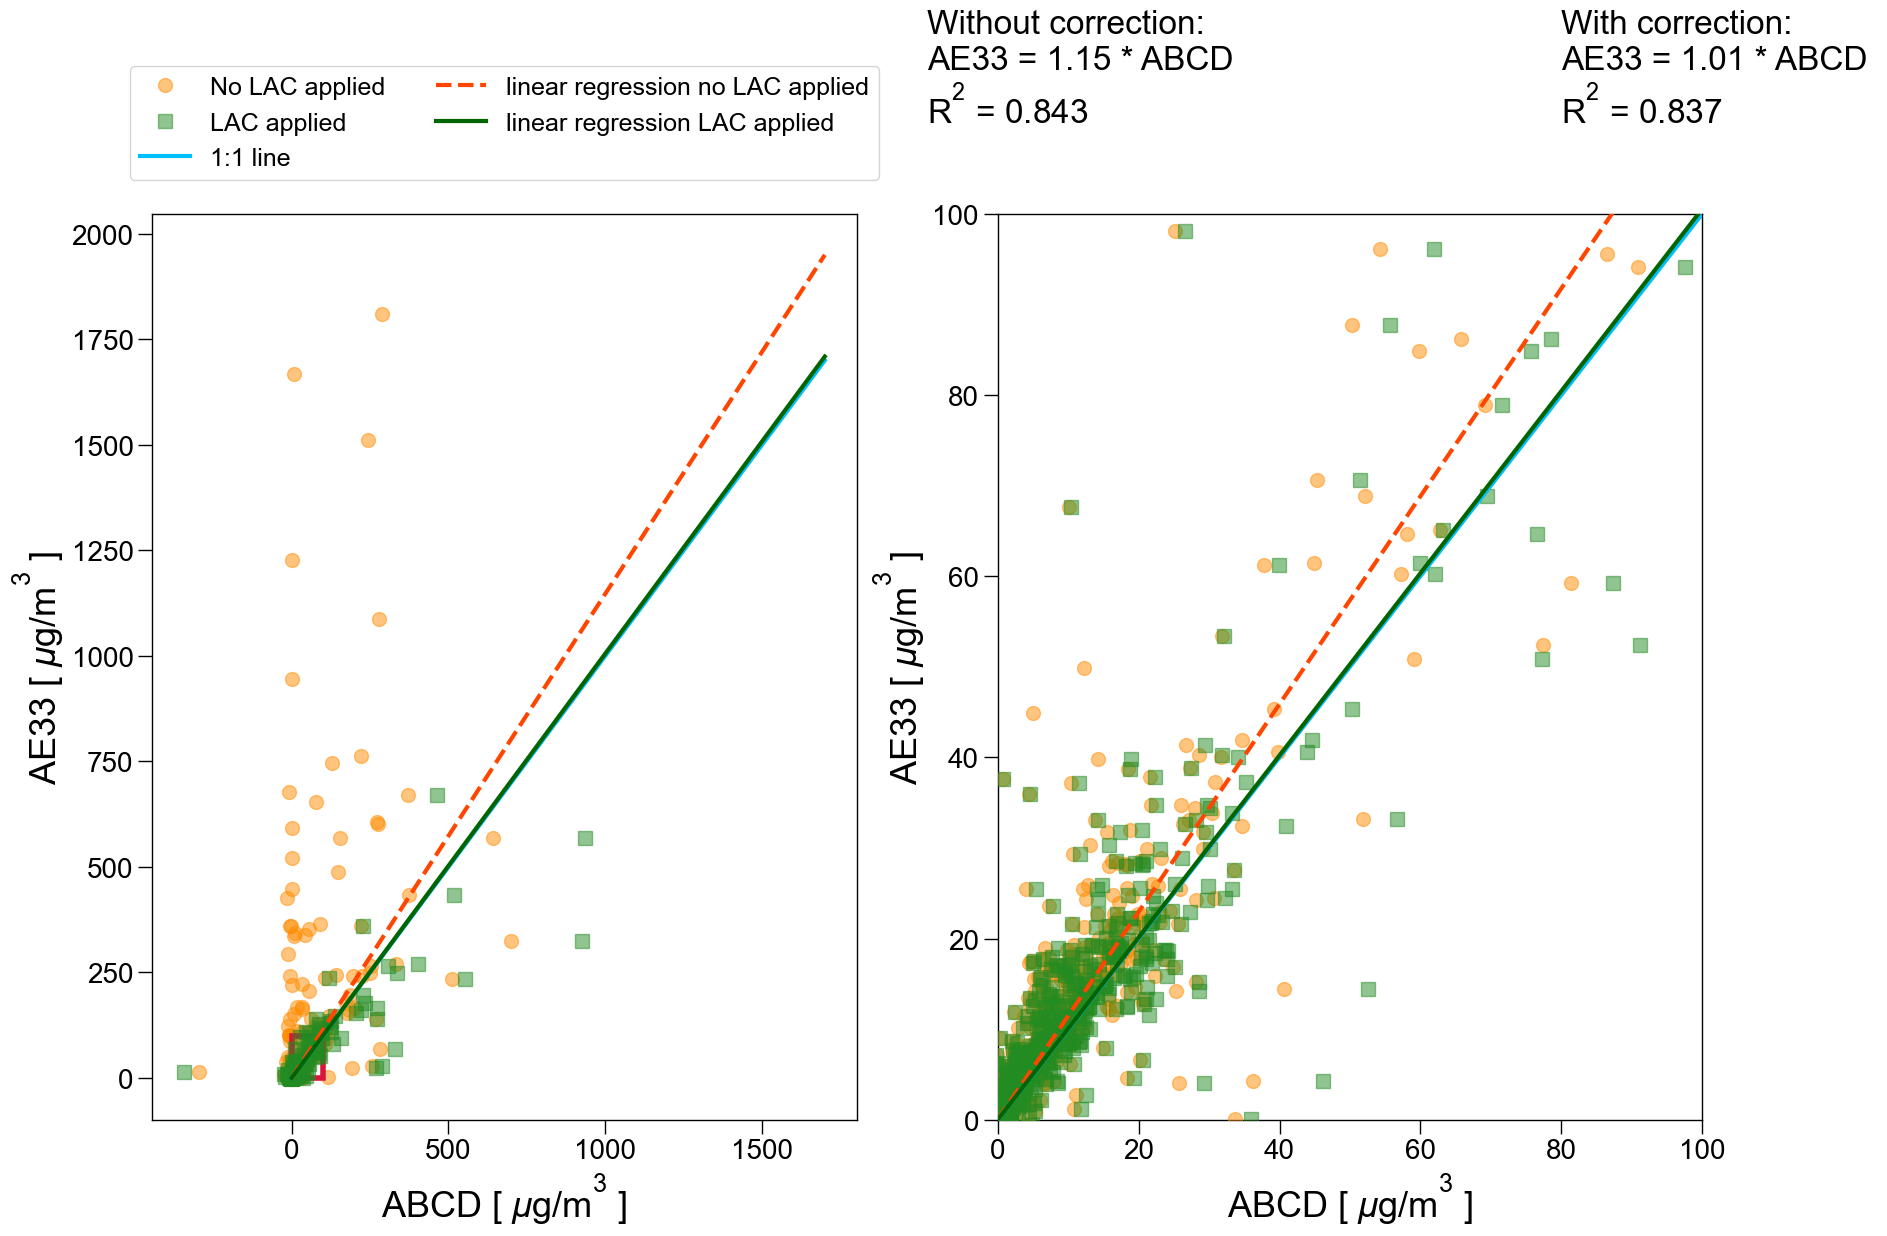

<Figure size 2000x1200 with 0 Axes>

In [107]:
figC, axC = plt.subplots(1,2)

bound = 100
end = 1700
x = np.linspace(0,end,11)

axC[0].add_patch(Rectangle((0, 0), bound, bound, edgecolor = '#DC143C', facecolor = 'none', fill=True,lw=4,zorder = 10))
axC[0].plot(MIN.BC,MIN.BC6,'o',color = '#FF8C00',zorder = 5,alpha = 0.5,label = 'No LAC applied')
axC[0].plot(MIN['BC_corr_' + str(AAPbest)],MIN.BC6,'s',color ='#228B22',zorder = 10,alpha = 0.5,label = 'LAC applied')
axC[0].plot([0,end],[0,end],color = '#00BFFF',zorder = 15, label = '1:1 line')

#no LAC applied linear regression
axC[0].plot(x,smin*x,'--', color ='#FF4500',zorder = 20,label = 'linear regression no LAC applied')
#axC[0].plot(x,b1lci + s1lci*x,'--',color ='#FF4500',label = '95% confidence interval')
#axC[0].plot(x,b1uci + s1uci*x,'--',color ='#FF4500')

#LAC applied linear regression
axC[0].plot(x,x*OLS.loc[AAPbest,'slope min'],'-',color ='#006400',zorder = 20,label = 'linear regression LAC applied')
#axC[0].plot(x,b1lci + s1lci*x,'--',color ='#FF4500',label = '95% confidence interval')
#axC[0].plot(x,b1uci + s1uci*x,'--',color ='#FF4500')

axC[0].set_ylabel('AE33 [ $\mu$g/m$^3$ ]',fontsize = 26)
axC[0].set_xlabel('ABCD [ $\mu$g/m$^3$ ]',fontsize = 26)
axC[0].legend(loc = 10,bbox_to_anchor = (0.5,1.1),ncol=2,fontsize=18)


axC[1].plot(MIN.BC,MIN.BC6,'o',color = '#FF8C00',zorder = 5,alpha = 0.5,label = 'No LAC applied')
axC[1].plot(MIN['BC_corr_' + str(AAPbest)],MIN.BC6,'s',color ='#228B22',zorder = 10,alpha = 0.5,label = 'LAC applied')
axC[1].plot([0,end],[0,end],color = '#00BFFF',zorder = 15)
axC[1].plot(x, smin*x,'--', color ='#FF4500',zorder = 20)
axC[1].plot(x,x*OLS.loc[AAPbest,'slope min'], color ='#006400',zorder = 20)
axC[1].set_ylabel('AE33 [ $\mu$g/m$^3$ ]',fontsize = 26)
axC[1].set_xlabel('ABCD [ $\mu$g/m$^3$ ]',fontsize = 26)
axC[1].set_xlim([0,bound])
axC[1].set_ylim([0,bound])
axC[1].text(-10,110,'Without correction:' + '\nAE33 =' + ' {:.2f}'.format(smin) + ' * ABCD '  + '\nR$^2$ = ' + '{:.3f}'.format(r2min), fontsize = 24)
axC[1].text(80,110,'With correction:'+ '\nAE33 =' + ' {:.2f}'.format(OLS.loc[AAPbest,'slope min']) + ' * ABCD ' + '\nR$^2$ = ' + '{:.3f}'.format(OLS.loc[AAPbest,'r2 min']), fontsize = 24)

#axC[1].plot(x,b1lci + s1lci*x,'--',color ='#DC143C')
#axC[1].plot(x,b1uci + s1uci*x,'--',color ='#DC143C')

plt.show()
plt.tight_layout()
path='/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/plots/ABCD-AE33 analyses/'
#figC.savefig('ABCD_AE33_compare.png')

In [108]:
mask = ~np.isnan(MIN.BC6) & ~np.isnan(MIN.BC)
rmseU = mean_squared_error(MIN.BC6[mask],MIN.BC[mask],squared=False)
mask = ~np.isnan(MIN.BC6) & ~np.isnan(MIN['BC_corr_' + str(AAPbest)])
rmseC = mean_squared_error(MIN.BC6[mask],MIN.loc[mask,'BC_corr_'+str(AAPbest)],squared=False)

In [109]:
OLS.loc[AAPbest,'r2 min']

0.837267831200261

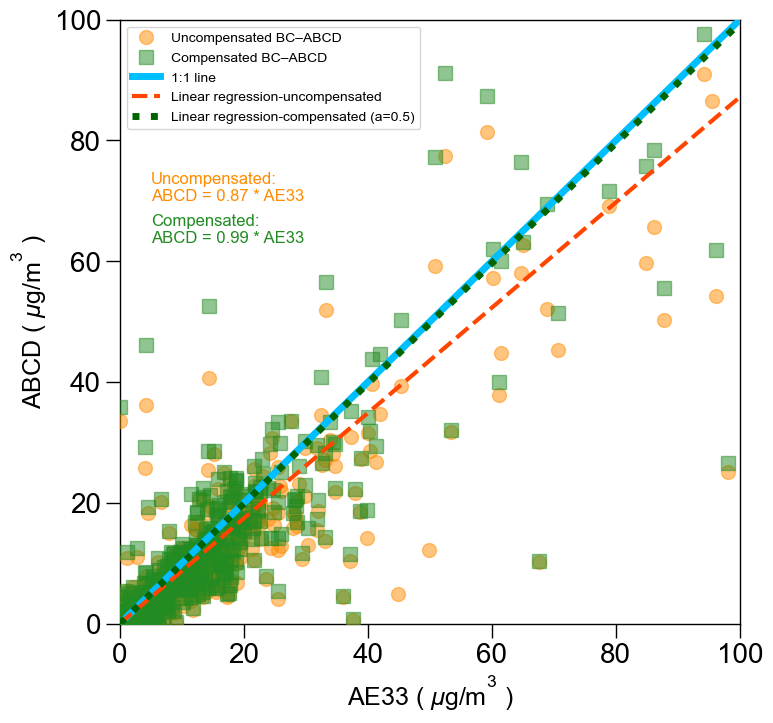

<Figure size 2000x1200 with 0 Axes>

In [110]:
fig, ax = plt.subplots(figsize=(8,8))

x = np.linspace(0,bound,11)
ax.plot(MIN.BC6,MIN.BC,'o',color = '#FF8C00',zorder = 5,alpha = 0.5,label = 'Uncompensated BC–ABCD')
ax.plot(MIN.BC6,MIN['BC_corr_' + str(AAPbest)],'s',color ='#228B22',zorder = 10,alpha = 0.5,label = 'Compensated BC–ABCD')

ax.plot([0,end],[0,end],color = '#00BFFF',lw = 5,zorder = 15,label = '1:1 line')
ax.plot(x, 1/smin*x,'--', color ='#FF4500',zorder = 20,label = 'Linear regression-uncompensated')
ax.plot(x,x*(1/(OLS.loc[AAPbest,'slope min'])),':',lw=5, color ='#006400',zorder = 20,label = 'Linear regression-compensated (a=0.5)')


ax.set_xlabel('AE33 ( $\mu$g/m$^3$ )')
ax.set_ylabel('ABCD ( $\mu$g/m$^3$ )')
ax.set_xlim([0,bound])
ax.set_ylim([0,bound])
ax.text(5,70,'Uncompensated:\nABCD = {:.2f} * AE33'.format(1/smin),fontsize = 12,color = '#FF8C00') #| RMSE = {:.2f} [$\mu$g/m$^3$] rmseU
ax.text(5,63,'Compensated:\nABCD = {:.2f} * AE33'.format(1/(OLS.loc[AAPbest,'slope min'])),fontsize = 12,color='#228B22') #| RMSE = {:.2f}  [$\mu$g/m$^3$] ,rmseC

ax.legend(loc='best',fontsize=10)

plt.show()
plt.tight_layout()
path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/clean plots/'
fig.savefig(path+'ABCD_AE33_inset.png')

In [111]:
OLS.loc[AAPbest,'slope min']

1.005404853855913

# Ratio vs ATN 

## 10 second basis

In [112]:
i = (S10.BC > BC_10_mae) & (S10.BC6 > BC6_10_mae)
j = (S10['BC_corr_'+str(AAPbest)]>BC_10_mae) & (S10.BC6 > BC6_10_mae)

BC_10 = S10.BC[i]
BC6_101 = S10.BC6[i]

BCc_10 = S10['BC_corr_'+str(AAPbest)][j]
BC6_102 = S10.BC6[j]

r10_u = BC_10 / BC6_101
r10_a = BCc_10 / BC6_102

In [113]:
s10u,b10u,r210u = linRegConst(S10.ATN[i],r10_u)
s10a,b10a,r210a = linRegConst(S10.ATN[j],r10_a)

## 1 minute basis

In [114]:
m = (MIN.BC > BC_min_mae) & (MIN.BC6 > BC6_min_mae)
n = (MIN['BC_corr_'+str(AAPbest)] > BC_min_mae) & (MIN.BC6 > BC6_min_mae)

BC_min = MIN.BC[m]
BC6_min1 = MIN.BC6[m]

BCc_min = MIN['BC_corr_'+str(AAPbest)][n]
BC6_min2 = MIN.BC6[n]

ratio_u = BC_min / BC6_min1
ratio_a = BCc_min / BC6_min2

In [115]:
sU, bU, r2U = linRegConst(MIN.ATN[m],ratio_u)
sA,bA,r2A = linRegConst(MIN.ATN[n],ratio_a)

x = np.arange(0,101)

## Plot

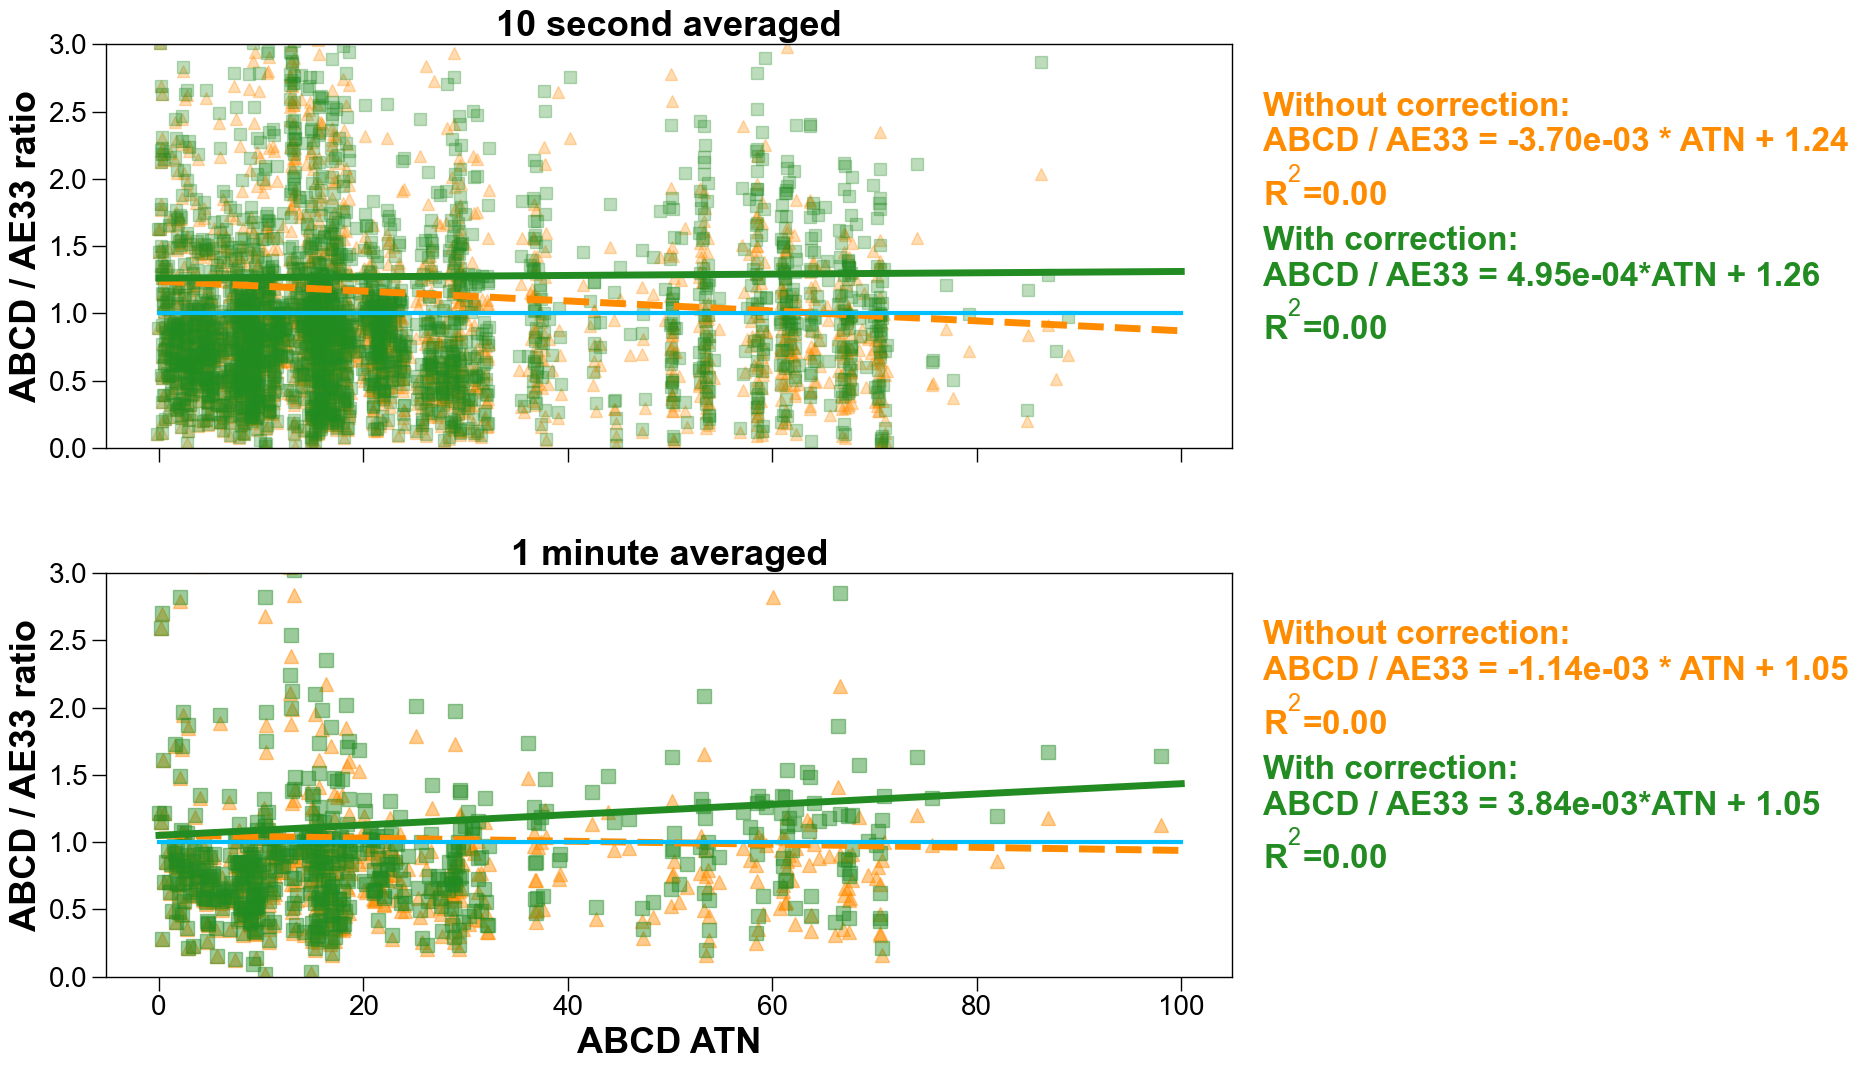

In [116]:
fig, ax = plt.subplots(2,1,sharex=True)

ax[0].plot(S10.ATN[i],r10_u,'^',color='#FF8C00',alpha=0.3,label='Uncorrected ABCD',ms=8)
ax[0].plot(S10.ATN[j],r10_a,'s',color='#228B22',alpha=0.3,label='Corrected ABCD, a = 0.5',ms=8)

ax[0].plot(x,x*s10u+b10u,'--',color = '#FF8C00',lw=5)
ax[0].plot(x,x*s10a+b10a,'-',color='#228B22',lw=5)

ax[0].plot([0,100],[1,1],'-',color='#00BFFF')
ax[0].set_ylabel('ABCD / AE33 ratio',fontsize=26,fontweight='bold')

ax[0].set_ylim([0,3])
ax[0].set_title('10 second averaged',fontsize = 26,fontweight = 'bold')
ax[0].text(108,1.8,'Without correction:\nABCD / AE33 = {:.2e} * ATN + {:.2f}\nR$^2$={:.2f}'.format(s10u,b10u,r210u), fontsize = 24,fontweight='bold',color = '#FF8C00')
ax[0].text(108,0.8,'With correction:\nABCD / AE33 = {:.2e}*ATN + {:.2f}\nR$^2$={:.2f}'.format(s10a,b10a,r210a), fontsize = 24,fontweight = 'bold',color='#228B22')
#----------------------------------------------------------------------------------------------------
ax[1].plot(MIN.ATN[m],ratio_u,'^',color='#FF8C00',alpha=0.45,label='Uncorrected ABCD',ms=10)
ax[1].plot(MIN.ATN[n],ratio_a,'s',color='#228B22',alpha=0.45,label='Corrected ABCD, a = 0.5',ms=10)

ax[1].plot(x,x*sU+bU,'--',color = '#FF8C00',lw=5)
ax[1].plot(x,x*sA+bA,'-',color='#228B22',lw=5)

ax[1].plot([0,100],[1,1],'-',color='#00BFFF')
ax[1].set_ylabel('ABCD / AE33 ratio',fontsize=26,fontweight='bold')
ax[1].set_xlabel('ABCD ATN',fontsize=26,fontweight='bold')

ax[1].set_title('1 minute averaged',fontsize = 26,fontweight = 'bold')
ax[1].set_ylim([0,3])
ax[1].text(108,1.8,'Without correction:\nABCD / AE33 = {:.2e} * ATN + {:.2f}\nR$^2$={:.2f}'.format(sU,bU,r2U), fontsize = 24,fontweight='bold',color = '#FF8C00')
ax[1].text(108,0.8,'With correction:\nABCD / AE33 = {:.2e}*ATN + {:.2f}\nR$^2$={:.2f}'.format(sA,bA,r2A), fontsize = 24,fontweight = 'bold',color='#228B22')

fig.tight_layout(pad=3)
#fig.savefig('ABCD-AE33_vs_ABCD-ATN.tiff')